# Pick Matrix

This notebook will investigate the Pick matrix when the spectral function $\rho(\omega)$ is a sum of delta functions with amplitudes $\{\mathcal Z_n\}$ at energies $\{\Omega_n\}$, of the form
\begin{equation}
    \rho(\omega) = \sum_n \mathcal Z_n \delta(\omega - \Omega_n).
\end{equation}
This is the case for all finite-volume spectral functions. We have:
\begin{equation}
    G_E(\tau) = \int d\omega\, K_\pm(\omega, \tau) \rho(\omega) = \int d\omega\, \frac{e^{-\omega\tau} + e^{-\omega (\beta - \tau)}}{1 \pm e^{-\beta\omega}} \rho(\omega) = \sum_n \mathcal Z_n \frac{e^{-\Omega_n\tau} + e^{-\Omega_n (\beta - \tau)}}{1 \pm e^{-\beta\Omega_n}}
\end{equation}
where $K_\pm$ is the boson (+) / fermion (-) kernel. The Fourier coefficients are defined as
\begin{equation}
    G_\ell = \int_0^\beta d\tau\, e^{i\omega_\ell \tau} G_E(\tau)
\end{equation}
and are equal to the retarded correlator, evaluated at the appropriate Matsubara frequencies $\omega_\ell = \frac{2\pi}{\beta} (\ell + \frac{1}{2})$,
\begin{equation}
    G_R(i\omega_\ell) = G_\ell
\end{equation}

Seaborne with context 'paper', fontscale = 12 / 9.6 (9.6 or 9.2, whatever the default fontsize for Seaborne is)

In [1]:
import os
import sys
from time import time
import numpy as np
import h5py 
import seaborn as sns
import scipy.interpolate as interpolate

PREC = 256
import gmpy2 as gmp
gmp.get_context().precision = PREC

from importlib import reload

sys.path.append('/Users/theoares/lqcd/utilities')
import plottools as pt
from formattools import *
# import formattools as ft
pt.set_font()
# style = styles['notebook']
default_style = styles['notebook']

import numpy as np

sys.path.append('/Users/theoares/lqcd_analysis/lqcd_analysis')
# from lqcd_analysis import visualize as plt
import visualize as plt
# import matplotlib.pyplt as plt

sys.path.append('/Users/theoares/lqcd/spectral/recon_tools')
# from inverse_problems import jax_spline
import jax_spline

sys.path.append('/Users/theoares/inverse_problems/inverse_problems')
from inverse_problems import nevanlinna as nv

# Helper functions

In [2]:
def mpc_conj(c):
    conj_c = np.zeros(c.shape, dtype = object)
    for ii, x in enumerate(c):
        conj_c[ii] = gmp.mpc.conjugate(x)
    return conj_c
def mpc_abs(c):
    """Input c should be a list of gmp.mpc objects."""
    abs_c = np.zeros(c.shape, dtype = object)
    for ii, x in enumerate(c):
        abs_c[ii] = gmp.sqrt(gmp.mpc.conjugate(x) * x).real
    return abs_c

In [3]:
def phase(z):
    return np.exp(1j*np.arctan2(z.imag, z.real))

def generate():
    os.system("pwd; python3 generate_PICK.py /Users/theoares/lqcd/spectral/simulations/data_PICK.h5;")

def run(eta="0.0001"):
    os.system(f"/Users/theoares/inverse_problems/nevanlinna_disk/Nevanlinna /Users/theoares/lqcd/spectral/simulations/data_PICK.h5 /Users/theoares/lqcd/spectral/simulations/recon_PICK.h5 {eta}")
    
def read_ng(fname):
    fname = '/Users/theoares/lqcd/spectral/simulations/' + fname
    with h5py.File(fname, 'r') as ifile:
        # print(ifile['freqs_imag'][:])
        freq_re = np.array(ifile['freqs_real'][:], dtype=float)
        freq_im = np.array(ifile['freqs_imag'][:], dtype=float)
        ng_re = np.array(ifile['ng_real'][:], dtype=float)
        ng_im = np.array(ifile['ng_imag'][:], dtype=float)
        freq = freq_re + 1j*freq_im
        ng = ng_re + 1j*ng_im
    return freq, ng

def read_phis(fname):
    fname = '/Users/theoares/lqcd/spectral/simulations/' + fname
    with h5py.File(fname, 'r') as ifile:
        #phis_re = np.array(ifile['phi_real'][:], dtype=float)
        #phis_im = np.array(ifile['phi_imag'][:], dtype=float)
        phis_re = np.array([gmp.mpfr(x) for x in ifile['phi_real'][()]], dtype = object)
        phis_im = np.array([gmp.mpfr(x) for x in ifile['phi_imag'][()]], dtype = object)
        phis = phis_re + 1j*phis_im
    return phis

def read(fname):
    fname = '/Users/theoares/lqcd/spectral/simulations/' + fname
    with h5py.File(fname, 'r') as ifile:
        # Reconstructed frequencies
        start = np.array(ifile['start'][:], dtype=float).item()
        stop = np.array(ifile['stop'][:], dtype=float).item()
        num = np.array(ifile['num'][:], dtype=int).item()
        omega = np.linspace(start, stop, num=num)
        
        # Reconstruction
        real = np.array(ifile['recon_real'][:], dtype=float)
        imag = np.array(ifile['recon_imag'][:], dtype=float)
        rho = real + 1j*imag
    return omega, rho, start, stop

def read_nev_coeffs(fname):
    fname = '/Users/theoares/lqcd/spectral/simulations/' + fname
    with h5py.File(fname, 'r') as ifile:
        print(ifile.keys())
        
        # Reconstructed frequencies
        start = np.array(ifile['start'][:], dtype=float).item()
        stop = np.array(ifile['stop'][:], dtype=float).item()
        num = np.array(ifile['num'][:], dtype=int).item()
        omega = np.linspace(start, stop, num=num)
        tmp = {}
        for key in ['P','Q','R','S']:
            tmp[f'{key}_re'] = np.array(ifile[f'{key}_real'][:], dtype=float)
            tmp[f'{key}_im'] = np.array(ifile[f'{key}_imag'][:], dtype=float)
        
        # DON'T NORMALIZE: destroys the identities we want to keep intact
        # norm = np.max(np.array(list(tmp.values())))
        # for key in tmp:
        #     tmp[key] = tmp[key]/norm
        nev_coeffs = {}
        
        # Rephase a,b,c,d
        for key in ['P','Q','R','S']:
            nev_coeffs[key] = tmp[f'{key}_re'] + 1j*tmp[f'{key}_im']        
        phi = phase(nev_coeffs['P'][0])
        for key in nev_coeffs:
            nev_coeffs[key] = nev_coeffs[key]/phi
    return omega, nev_coeffs

def read_pick(fname):
    fname = '/Users/theoares/lqcd/spectral/simulations/' + fname
    with h5py.File(fname, 'r') as ifile:
        eigs = np.array([gmp.mpfr(x) for x in ifile['eigs_real'][()]], dtype = object)
        npts = len(eigs)
        pick = np.zeros((npts, npts), dtype = object)
        eigvecs = np.zeros((npts, npts), dtype = object)
        for ii in range(npts):
            eigvecs_ii_re = np.array([gmp.mpfr(x) for x in ifile['eigvecs_' + str(ii) + '_real'][()]], dtype = object)
            eigvecs_ii_im = np.array([gmp.mpfr(x) for x in ifile['eigvecs_' + str(ii) + '_imag'][()]], dtype = object)
            eigvecs[ii] = eigvecs_ii_re + 1j*eigvecs_ii_im
            
            pick_ii_re = np.array([gmp.mpfr(x) for x in ifile['pick_' + str(ii) + '_real'][()]], dtype = object)
            pick_ii_im = np.array([gmp.mpfr(x) for x in ifile['pick_' + str(ii) + '_imag'][()]], dtype = object)
            pick[ii] = pick_ii_re + 1j*pick_ii_im
    return pick, eigs, eigvecs

def build_bspline(x, y):
    t, c, k = interpolate.splrep(x, y, s=0, k=4)
    bspline = interpolate.BSpline(t, c, k, extrapolate=False)
    return bspline    

def kernel(x, x0, sigma):
    dx = x - x0
    return np.exp(-0.5*dx**2/sigma**2) / (np.sqrt(2*np.pi) * sigma)

In [4]:
def analytic_ft(z, m, beta):
    prefactor = -1*(1 + np.exp(-m*beta))
    pole1 = 1/(z - m)
    pole2 = 1/(z + m)
    return prefactor * (pole1 + pole2)

# Generate data, run reconstruction

In [5]:
# Generate data
generate()

# Compute spectral function
# eta_str = '1.0'
# eta_str = '0.5'
# eta_str = '0.2'
# eta_str = '0.15'
# eta_str = '0.1'        # default
# eta_str = '0.05'
eta_str = '0.01'
# eta_str = '0.0001'
# eta_str = '1e-8'
# eta_str = '1e-12'
# eta_str = '1e-16'
eta = float(eta_str)
run(eta = eta_str)

# Read spectral
omega, rho, start, stop = read("recon_PICK.h5")

/Users/theoares/lqcd/spectral/python_scripts
Writing data to: /Users/theoares/lqcd/spectral/simulations/data_PICK.h5
Green's function data written to: /Users/theoares/lqcd/spectral/simulations/data_PICK.h5

Running Nevanlinna.
Reading input from: /Users/theoares/lqcd/spectral/simulations/data_PICK.h5
Writing output to: /Users/theoares/lqcd/spectral/simulations/recon_PICK.h5
Running reconstruction with eta = 0.01
Number of measured Matsubara frequencies: 20
Beta is: 48

Matsubara frequencies:
[0 + 0.130899693899574718269276807636645953508215391640629409207289358i, 0 + 0.261799387799149436538553615273291907016430783281258818414578716i, 0 + 0.392699081698724154807830422909937860524646174921888227621868074i, 0 + 0.5235987755982988730771072305465838140328615665625176368291574321i, 0 + 0.6544984694978735913463840381832297675410769582031470460364467901i, 0 + 0.7853981633974483096156608458198757210492923498437764552437361481i, 0 + 0.9162978572970230278849376534565216745575077414844058644510255

Singular values:     (9.070778723932302888159862158077756139732174170450571729831758209,0)
(4.464855270131178292107070004998435527184161147974835389661136187e-16,0)
(4.007231379204803615910930211957207287631951680306112232861560647e-16,0)
(3.724321106634167010656144693043652553688901748212637587434514709e-16,0)
(3.293850526520306942448235266638256661891310843818056957664266875e-16,0)
(3.185265179535277487595420320985737452129805366831808978355996105e-16,0)
(3.030090799608259348335422349845712958745667379847352630096862576e-16,0)
(2.670139806279944957230854107522868230190886966189681246872262917e-16,0)
(2.467145374279074946842869214923273886083447784254415494544155493e-16,0)
(2.057164860263438815938990651163617578789234462397619026123094176e-16,0)
(1.995108899819070803267218408296694897521171329034976981841377071e-16,0)
(1.571542311490998719028288591912265771340268168660436799254500261e-16,0)
(1.366252952305177128040660842342540677336390755885138936539094134e-16,0)
(1.228589806375378073

Spectral function reconstructed.

Recon written to: /Users/theoares/lqcd/spectral/simulations/recon_PICK.h5


## Plot results

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':"Nevanlinna Green's function"}, xlabel='$2\\pi\\omega_n$', ylabel='$C(i\\omega_n)$'>)

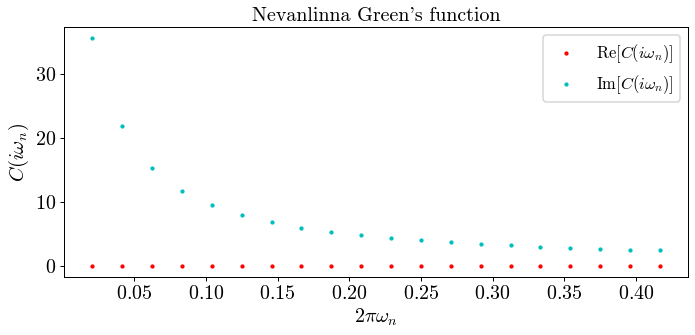

In [6]:
reload(pt)

# NG Green function - on imaginary axis
freq, ng = read_ng("recon_PICK.h5")
phis = read_phis("recon_PICK.h5")

# Solve the interpolation problem on the disk of w_i = f(z_i)
zeta_list = nv.moebius(freq)
w_list = nv.moebius(ng)

x = freq.imag / (2*np.pi)
pt.scatter_1d(x, ng, ax_label = [r'$2\pi\omega_n$', r'$C(i\omega_n)$'], mkr = '.', fn_label = r'C(i\omega_n)', \
              title = 'Nevanlinna Green\'s function', legend = True)

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:xlabel='$\\omega$', ylabel='$\\rho$'>)

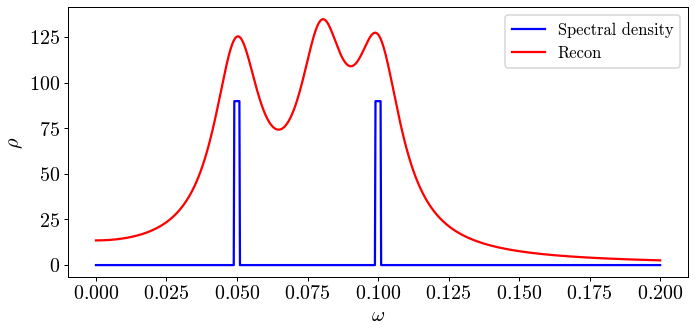

In [7]:
freq, ng = read_ng("recon_PICK.h5")

# Expected spectral density (delta function)
rho_gt = np.zeros((1000))
rho_gt[np.logical_and(omega > 0.049, omega < 0.051)] = np.max(rho.imag * 2/3)
rho_gt[np.logical_and(omega > 0.099, omega < 0.101)] = np.max(rho.imag * 2/3)

fig, ax = pt.plot_1d_data(omega, rho_gt, col = 'b', fn_label = 'Spectral density')

# Reconstructed spectral density
f = build_bspline(omega, rho.imag)
pt.plot_1d_data(omega, rho.imag, ax = ax, ax_label = [r'$\omega$', r'$\rho$'], fn_label = 'Recon', legend = True)

In [8]:
# TODO: figure out normalization
np.trapz(rho.imag)

47110.1626724435

#### TODO: use actual delta functions and do this analytically

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Smearing kernel'}, xlabel='$\\omega$', ylabel='$\\delta_\\epsilon$'>)

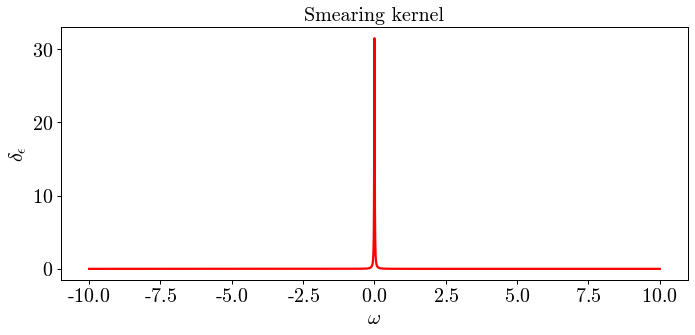

In [9]:
# Smear spectral function rho_gt
omega_conv = np.linspace(-10, 10, num=10000)
sigma = 0.1
rho_gt_full = np.exp(-0.5*(omega_conv - 0.5)**2/sigma**2)/(np.sqrt(2*np.pi)*sigma)
rho_gt_full += np.exp(-0.5*(omega_conv + 0.5)**2/sigma**2)/(np.sqrt(2*np.pi)*sigma)

def delta_eps(z, epsilon = eta):
    return (epsilon / np.pi) / (z**2 + epsilon**2)
delta_eps_grid = np.array([delta_eps(w) for w in omega_conv], dtype = np.float64)
pt.plot_1d_data(omega_conv, delta_eps_grid, ax_label = [r'$\omega$', r'$\delta_\epsilon$'], title = 'Smearing kernel')

(-1.0, 1.0)

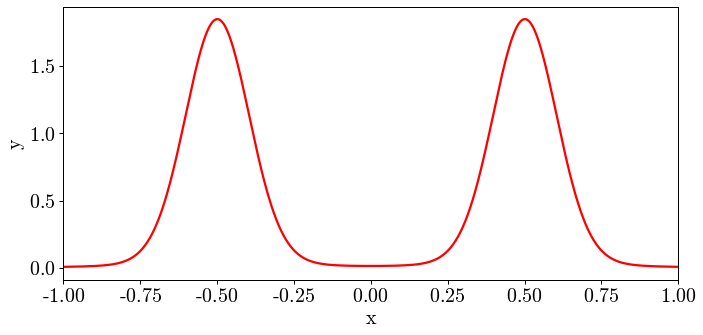

In [10]:
Delta_omega = (1/2) * (np.max(omega_conv) - np.min(omega_conv)) / len(omega_conv)            # Convert sum to integral
# Delta_omega = (np.max(omega_conv) - np.min(omega_conv)) / len(omega_conv)            # Convert sum to integral
rho_smeared_full = np.convolve(delta_eps_grid, rho_gt_full, 'same') * Delta_omega
fig, ax = pt.plot_1d_data(omega_conv, rho_smeared_full)
ax.set_xlim((-1, 1))
# rho_smeared = rho_smeared_full[np.logical_and(x >= -1.0, x <= 1.0)]

## Pick matrix

The Pick matrix is defined as
\begin{equation}
    \mathcal P_{ij} = \frac{1 - w_i \overline{w_j}}{1 - \zeta_i \overline{\zeta_j}}
\end{equation}
where $\{w_i\}$ are the Cayley transforms of the input Green's function, and $\{\zeta_i\}$ are the Cayley transforms of the Matsubara frequencies. Note that if the input Green's function is imaginary, then $w_i\in\mathbb R$ since the Cayley transform maps $\mathbb I$ into $\mathbb D\cap \mathbb R$, and likewise the $\{\zeta_i\}$ are always real. Hence in this case this simplifies to the real, symmetric matrix
\begin{equation}
    \mathcal P_{ij} = \frac{1 - w_i w_j}{1 - \zeta_i \zeta_j}.
\end{equation}
The **Pick criterion** says that an interpolating function $f$ in the Schur class $\mathcal S$ exists iff the Pick matrix $\mathcal P$ is positive semi-definite, i.e. if all of its eigenvalues $\lambda\geq 0$. This is a very sensitive condition to impose on the matrix, and it is useful to study cases of data both where the Pick criterion passes, and where it fails. 

In [11]:
pick, eigs, eigvecs = read_pick('recon_PICK.h5')
eigs

array([mpfr('-7.756833161009212732653852940827555934935441868090669770565901209999999999999971e-19',256),
       mpfr('3.719271812781470529257774856605942278839753682291637286192284054999999999999999e-17',256),
       mpfr('4.70521822460658278106378193446874624043318034866703735068200014300000000000002e-17',256),
       mpfr('1.183243735615909678159510624724993754190441743705564897948683845000000000000008e-16',256),
       mpfr('-1.273815270791345196636477274551737329760158596230708155692971613999999999999996e-16',256),
       mpfr('1.937517723061622838567330963086664624327701646720719218694917617000000000000003e-16',256),
       mpfr('-1.966273742165691923479952515876651470268098182917656970969770461999999999999995e-16',256),
       mpfr('-2.098574520007391211509745079230683649213526661238681346358749523999999999999995e-16',256),
       mpfr('2.304792614680314383660662365435029607533709749539542245045863766999999999999986e-16',256),
       mpfr('-2.891860200255824574985959451183499139

In [12]:
# Eigenvalue decomposition
pick_decomp = eigvecs.T @ np.diag(eigs) @ eigvecs
print('Pick matrix:\n' + str(pick))
print('\nPick matrix - U^TDU: \n' + str(pick - pick_decomp))

Pick matrix:
[[mpc('0.25942354386132115973140344067360274493694305419921875+0.0j',(256,256))
  mpc('0.2492202131081429905545832070856704376637935638427734375+0.0j',(256,256))
  mpc('0.256753261076446970267994629466556943953037261962890625+0.0j',(256,256))
  mpc('0.268503408868862314395897783469990827143192291259765625+0.0j',(256,256))
  mpc('0.281598743371804183244222485882346518337726593017578125+0.0j',(256,256))
  mpc('0.2950878035526809384236912592314183712005615234375+0.0j',(256,256))
  mpc('0.3085782424078373775699901671032421290874481201171875+0.0j',(256,256))
  mpc('0.321887626097753176690474674614961259067058563232421875+0.0j',(256,256))
  mpc('0.33492598660969863377800948001095093786716461181640625+0.0j',(256,256))
  mpc('0.34764874416382196553598760146996937692165374755859375+0.0j',(256,256))
  mpc('0.3600353521464312311906041941256262362003326416015625+0.0j',(256,256))
  mpc('0.37207867970403885049535119833308272063732147216796875+0.0j',(256,256))
  mpc('0.383779349109241774

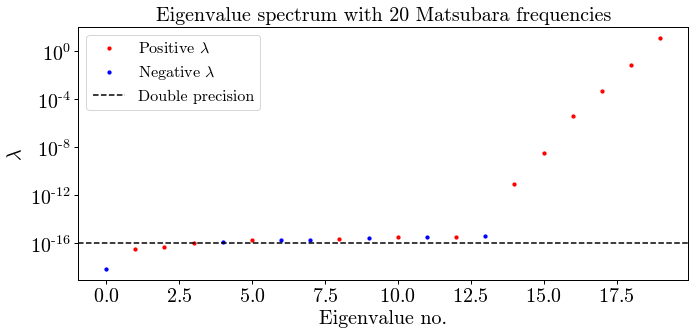

In [13]:
n_eigs = len(eigs)
eig_ids = range(n_eigs)
fig, ax = pt.scatter_1d(eig_ids, np.float64(eigs), logy=True, fn_label=r'Positive $\lambda$', col='r')
pt.scatter_1d(eig_ids, -np.float64(eigs), ax=ax, logy=True, fn_label=r'Negative $\lambda$', col='b',  \
              ax_label = [r'Eigenvalue no.', r'$\lambda$'], \
              title = r'Eigenvalue spectrum with ' + str(n_eigs) + ' Matsubara frequencies',)
pt.add_line(ax, 1e-16, c = 'k', label = 'Double precision', orientation = 'h', linestyle = 'dashed')
ax.legend(fontsize = 16)
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/tests/eig_spec_' + str(n_eigs) + 'freqs.pdf', \
#             bbox_inches = 'tight')

Phi values: [mpc('0.9454053959157785092702544134525897820225937004588133548952027121999999999999985+0.0j',(256,256))
 mpc('0.716246902572189794871492401489445248818585090219984990468640773799999999999998+0.0j',(256,256))
 mpc('-0.9718391321283835442352070162454419317708196555460305434830464682999999999999993+0.0j',(256,256))
 mpc('0.9543669338084328029469222628635904603143265141378391255901250543000000000000025+0.0j',(256,256))
 mpc('-0.9948538347626910037949690425636000979460037019563678597862893322000000000000015+0.0j',(256,256))
 mpc('0.9773738837860935717703403988323399557965097264243490530182269118000000000000001+0.0j',(256,256))
 mpc('-1.000000082288407139307674022541240687634970161080465853265694372000000000000004+0.0j',(256,256))
 mpc('-11.29889588844606685807448530065399655731559808939760776851453892999999999999999-1.413047460630479779102264036471539856050819393601563359394361388999999999999996e-64j',(256,256))
 mpc('0.0+0.0j',(256,256)) mpc('0.0+0.0j',(256,256))
 mpc('-80.079

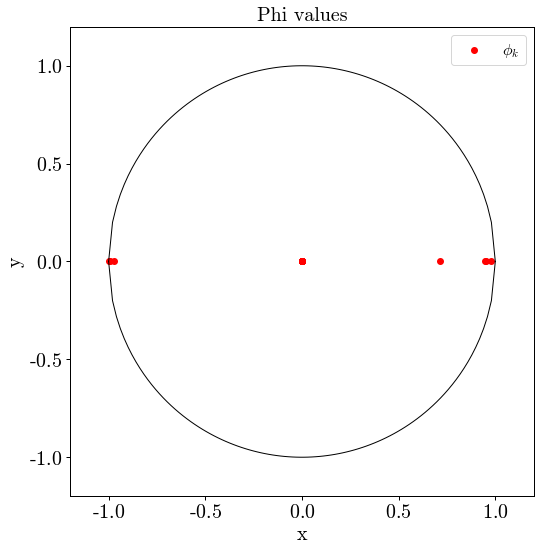

In [14]:
print('Phi values: ' + str(phis))
fig, ax = pt.scatter_1d(np.complex64(phis).real, np.complex64(phis).imag, fn_label = r'$\phi_k$', col = 'r', \
                        title = 'Phi values', mkr = 'o', style = styles['notebook_square'])
pt.add_circle(ax)
ax.set_ylim((-1.2, 1.2))
ax.set_xlim((-1.2, 1.2))
ax.legend(fontsize = 16)

### Eigenvalue cut on Pick matrix

Let $\mathcal P$ be the Pick matrix, and let $\mathcal P = U^T D U$ be the decomposition of $P$ as a matrix of eigenvectors $U$ and a diagonal matrix of eigenvalues $D$. Note that everything is real, under the assumption that the data $\{w_i\}$ and $\{\zeta_i\}$ are real. We wish to form a matrix $\mathcal P'$ which has positive eigenvalues, and use that as the Pick matrix for a different set of data $\{w_i'\}$. There are two simple ways to do this, essentially by replacing $D$ with another diagonal matrix $D'$. 
1. (Eigenvalue cut) Use $D'_{ii} = \max\{D_{ii}, \epsilon\}$ for some regulator $\epsilon\ll 1$.
2. Use $D' = |D|$, where here $|D|$ denotes taking the norm of each element in the diagonal matrix $D$.

Upon forming $D'$, one computes the new Pick matrix $\mathcal P' = U^T D' U$. To use this as the Pick matrix, we construct the matrix $W'$ defined element-wise as
\begin{equation}
    W'_{ij} = 1 - (1 - \zeta_i \zeta_j) \mathcal P_{ij}'
\end{equation}
The goal is to write $W'$ as the outer product of two vectors, $W_{ij}' = w_i' w_j'$. This is known as a **low rank approximation**, since the matrix $uv^T$ has rank 1 and the goal is to approximate $W'$ with $ww^T$. The easiest way to do this is to perform an SVD of $W'$, which will expand $W' = \sum_i \sigma_i u_i v_i^T$ with $\sigma_i$ the singular values. The low-rank approximation to $W'$ is then $W'\approx \sigma_1 u_1 v_1^T$, where $\sigma_1$ is the largest singular value. 

##### Notes
- In situtations where the Pick matrix is barely not positive-semidefinite (i.e. if the only offending eigenvalues $\lambda < 0$ satisfy $|\lambda| \simeq 10^{-16}$, which is floating-point precision) then doing this Pick regularization results in new data points $w_i'$ that are identical, up to double precision, to the original $w_i$. This should not be suprising, since at the floating-point level, these bad eigenvalues are equivalent to zero.
    - The question to ask here is how to study these at extended precision, which likely needs to be done in C++. 

In [15]:
# Perform low-rank approximation of original W_{ij} = w_i w_j.
W0_mat = np.outer(w_list, w_list)
U0, Sigma0, V0 = np.linalg.svd(W0_mat)
print('Singular values: ' + str(Sigma0))    # Note there should only be one large singular value
print('Singular vectors\n', V0[0, :], '\n', U0[:, 0])    # If these are the same, then we're good
w_new_list = np.sqrt(Sigma0[0]) * V0[0, :]
w_new_list *= w_new_list[0] / np.abs(w_new_list[0])
print('Original w:' + str(w_list))
print('New w: ' + str(w_new_list))

Singular values: [9.07077872e+00 1.10026280e-15 2.11719738e-16 1.73508102e-16
 1.37418167e-16 1.18640990e-16 1.02483384e-16 9.04450713e-17
 7.85653975e-17 7.19662332e-17 6.28017644e-17 5.92150557e-17
 4.93718226e-17 4.28082827e-17 3.59344938e-17 2.77442621e-17
 2.54185024e-17 1.84115075e-17 9.56296832e-18 9.79571158e-19]
Singular vectors
 [-0.31390323+0.j -0.30302952+0.j -0.2912495 +0.j -0.27956451+0.j
 -0.26817707+0.j -0.25714124+0.j -0.24646804+0.j -0.23615293+0.j
 -0.22618522+0.j -0.21655173+0.j -0.20723841+0.j -0.1982312 +0.j
 -0.18951632+0.j -0.18108052+0.j -0.17291114+0.j -0.16499614+0.j
 -0.15732411+0.j -0.14988425+0.j -0.14266633+0.j -0.13566071+0.j] 
 [-0.31390323+0.j -0.30302952+0.j -0.2912495 +0.j -0.27956451+0.j
 -0.26817707+0.j -0.25714124+0.j -0.24646804+0.j -0.23615293+0.j
 -0.22618522+0.j -0.21655173+0.j -0.20723841+0.j -0.1982312 +0.j
 -0.18951632+0.j -0.18108052+0.j -0.17291114+0.j -0.16499614+0.j
 -0.15732411+0.j -0.14988425+0.j -0.14266633+0.j -0.13566071+0.j]
Origi

In [16]:
# method 1. Note pick = eigvecs.T @ np.diag(eigs) @ eigvecs
size = (len(eigs), len(eigs))
eps = gmp.mpfr('1e-16')
eigs_p = np.array([eig if eig >= eps else eps for eig in eigs])
pick_p = eigvecs.T @ np.diag(eigs_p) @ eigvecs
Wp_mat = np.full(size, gmp.mpfr('1')) - (np.full(size, gmp.mpfr('1')) - np.outer(zeta_list, zeta_list)) * pick_p
Wp_mat_float = np.complex128(Wp_mat).real

In [17]:
U, Sigma, V = np.linalg.svd(Wp_mat_float)
print('Singular values: ' + str(Sigma))    # Note there should only be one large singular value
print('Singular vectors\n', V[0, :], '\n', U[:, 0])    # If these are the same, then we're good
wp_list = np.sqrt(Sigma[0]) * V[0, :]
wp_list *= wp_list[0] / np.abs(wp_list[0])        # rephase
print('Original w:' + str(w_list))
print('New w: ' + str(wp_list))

Singular values: [9.07077872e+00 3.47571537e-15 2.54602714e-15 9.81697925e-16
 4.08057126e-16 3.69259077e-16 3.14107797e-16 2.87084630e-16
 2.40452731e-16 2.10881248e-16 2.04637120e-16 1.92094083e-16
 1.66650539e-16 1.47647736e-16 1.04162241e-16 9.17937081e-17
 7.54427137e-17 4.94081329e-17 2.12879716e-17 1.03224780e-17]
Singular vectors
 [-0.31390323 -0.30302952 -0.2912495  -0.27956451 -0.26817707 -0.25714124
 -0.24646804 -0.23615293 -0.22618522 -0.21655173 -0.20723841 -0.1982312
 -0.18951632 -0.18108052 -0.17291114 -0.16499614 -0.15732411 -0.14988425
 -0.14266633 -0.13566071] 
 [-0.31390323 -0.30302952 -0.2912495  -0.27956451 -0.26817707 -0.25714124
 -0.24646804 -0.23615293 -0.22618522 -0.21655173 -0.20723841 -0.1982312
 -0.18951632 -0.18108052 -0.17291114 -0.16499614 -0.15732411 -0.14988425
 -0.14266633 -0.13566071]
Original w:[0.9454054 +0.j 0.91265623+0.j 0.87717749+0.j 0.84198495+0.j
 0.80768854+0.j 0.77445114+0.j 0.74230586+0.j 0.71123911+0.j
 0.68121863+0.j 0.65220472+0.j 0.624

In [18]:
Wp_mat

array([[mpc('0.8937913626266698439773827183688066759196050991340751730567553013792131295652705+0.0j',(256,256)),
        mpc('0.8628301241587103349022691444448752898045161051264926662251942399677919859329362+0.0j',(256,256)),
        mpc('0.8292883301149717240630335368376468600909096423610720764469088436940180167376602+0.0j',(256,256)),
        mpc('0.7960171133991060547856458457112710961501648756438614882337770881367227945560676+0.0j',(256,256)),
        mpc('0.7635931081248856377370127947937702767209638476692988360425376838475395122562837+0.0j',(256,256)),
        mpc('0.7321702868078390083875384842612074988068365456528087909512512689351909685103622+0.0j',(256,256)),
        mpc('0.7017799668189449338406355022884892477733910196380286404730470257864595107168203+0.0j',(256,256)),
        mpc('0.6724092893388459443353084675274394941141686789884835611368837479973784481530799+0.0j',(256,256)),
        mpc('0.6440277695579194017621916953421469892337519407541186620664042605470016388910733+0

Something to look for in the Pick Interpolation book: given an interpolation problem $\{(\zeta_i, w_i)\}_i$, an interpolant $f\in H^\infty$ will not exist if the Pick criterion is not satisfied. However, is there a way to find a "best" interpolant even when this condition is not satisfied? That is, to determine one of two things:
1. The closest set of data $\{(\zeta_i, w_i')\}$ (here "close" meaning that $\sum_i d(w_i, w_i')$ is minimized, where $d$ is some given metric, likely the pseudo-hyperbolic metric $\rho$) which satisfies the Pick criterion, and hence has an interpolating function $f\in H^\infty$.
2. The best approximation to an interpolating function, that is the function $f\in H^\infty$ which minimizes the interpolating distance $\sum_i d(f(\zeta_i), w_i)$. 

**Perhaps a good example to have for the paper is how finnicky the Pick matrix can be**: find an example of extended-precision data that has a positive-semidefinite Pick matrix, such that when you truncate it to double precision you get a non-positive-semidefinite Pick matrix. 

## Run with new w

In [20]:
def read_eig_cut(fname):
    fname = '/Users/theoares/lqcd/spectral/simulations/' + fname
    with h5py.File(fname, 'r') as ifile:
        new_w_re = np.array([gmp.mpfr(x) for x in ifile['new_w_real'][()]], dtype = object)
        new_w_im = np.array([gmp.mpfr(x) for x in ifile['new_w_imag'][()]], dtype = object)
        new_w = new_w_re + 1j*new_w_im
        new_ng_re = np.array([gmp.mpfr(x) for x in ifile['new_ng_real'][()]], dtype = object)
        new_ng_im = np.array([gmp.mpfr(x) for x in ifile['new_ng_imag'][()]], dtype = object)
        new_ng = new_ng_re + 1j*new_ng_im
    return new_w, new_ng
new_w, new_ng = read_eig_cut('recon_PICK.h5')

In [ ]:
def generate_eig_cut():
    os.system("pwd; python3 generate_eig_cut.py /Users/theoares/lqcd/spectral/simulations/data_EIG_CUT.h5 /Users/theoares/lqcd/spectral/simulations/data_PICK.h5;")

    

In [24]:
new_ng

array([mpc('0.0+35.63365699867832603331407881341874599456787109375j',(256,256)),
       mpc('0.0+21.898026874125125829095850349403917789459228515625j',(256,256)),
       mpc('0.0+15.2836597600145296382834203541278839111328125j',(256,256)),
       mpc('0.0+11.657022090206663023082001018337905406951904296875j',(256,256)),
       mpc('0.0+9.3997964868371699509452810161747038364410400390625j',(256,256)),
       mpc('0.0+7.86725830348335808395177082275040447711944580078125j',(256,256)),
       mpc('0.0+6.761138887845806522136626881547272205352783203125j',(256,256)),
       mpc('0.0+5.92614563460343646283945417962968349456787109375j',(256,256)),
       mpc('0.0+5.27389237443388037007707680459134280681610107421875j',(256,256)),
       mpc('0.0+4.7505092898646790189332023146562278270721435546875j',(256,256)),
       mpc('0.0+4.32134437783115199493977343081496655941009521484375j',(256,256)),
       mpc('0.0+3.963117067883468624955867198877967894077301025390625j',(256,256)),
       mpc('0.0+3.65

# Study Nevanlinna coefficients analytically

<KeysViewHDF5 ['P_imag', 'P_real', 'Q_imag', 'Q_real', 'R_imag', 'R_real', 'S_imag', 'S_real', 'beta', 'eigs_imag', 'eigs_real', 'eigvecs_0_imag', 'eigvecs_0_real', 'eigvecs_1_imag', 'eigvecs_1_real', 'eigvecs_2_imag', 'eigvecs_2_real', 'eigvecs_3_imag', 'eigvecs_3_real', 'eigvecs_4_imag', 'eigvecs_4_real', 'eta', 'freqs_imag', 'freqs_real', 'ng_imag', 'ng_real', 'num', 'phi_imag', 'phi_real', 'pick_0_imag', 'pick_0_real', 'pick_1_imag', 'pick_1_real', 'pick_2_imag', 'pick_2_real', 'pick_3_imag', 'pick_3_real', 'pick_4_imag', 'pick_4_real', 'recon_imag', 'recon_real', 'start', 'stop', 'w_list_imag', 'w_list_real', 'zeta_list_imag', 'zeta_list_real']>


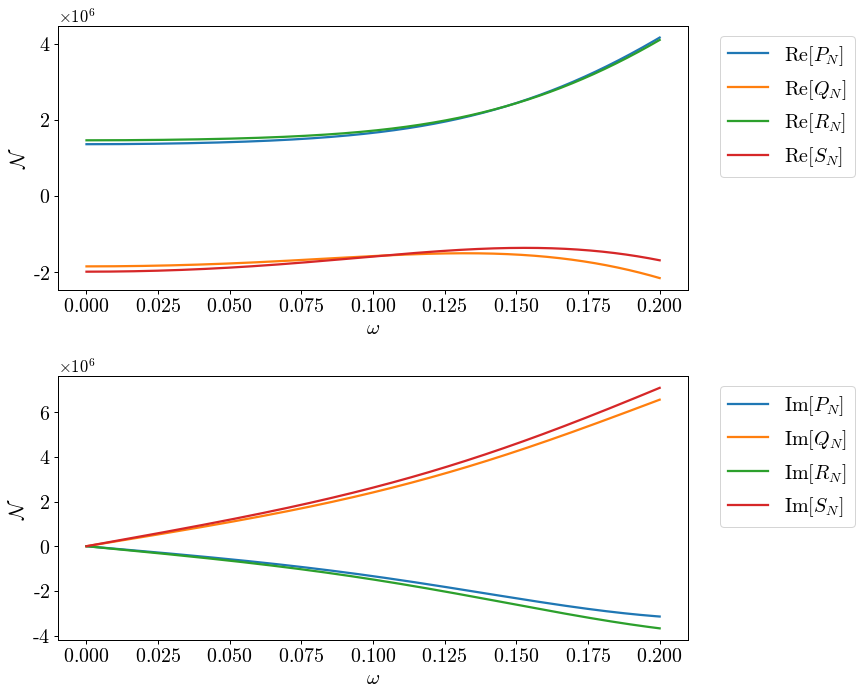

In [16]:
omega, nev_coeffs = read_nev_coeffs("recon_PICK.h5")
nev_cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, axes = pt.add_subplots(n_rows = 2)
[ax1, ax2] = axes
for ii, key in enumerate(['P','Q','R','S']):
    pt.plot_1d_data(omega, nev_coeffs[key].real, ax = ax1, col = nev_cols[ii], ax_label = [r'$\omega$', \
                      r'$\mathcal{N}$'], fn_label = r'$\mathrm{Re}['+key+'_N]$')
    pt.plot_1d_data(omega, nev_coeffs[key].imag, ax = ax2, col = nev_cols[ii], ax_label = [r'$\omega$', \
                      r'$\mathcal{N}$'], fn_label = r'$\mathrm{Im}['+key+'_N]$')

ax1.legend(bbox_to_anchor=(1.28, 1), loc='upper right', fontsize = default_style['fontsize'])
ax2.legend(bbox_to_anchor=(1.28, 1), loc='upper right', fontsize = default_style['fontsize'])

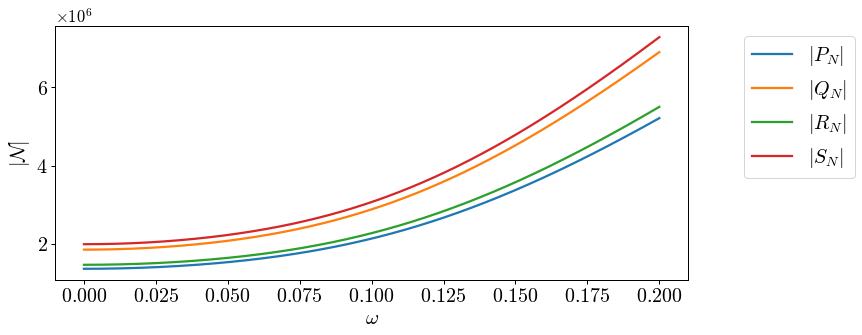

In [17]:
fig, axes = pt.add_subplots()
ax = axes[0]
for ii, key in enumerate(['P','Q','R','S']):
    pt.plot_1d_data(omega, np.abs(nev_coeffs[f"{key}"]), ax = ax, col = nev_cols[ii], \
                      ax_label = [r'$\omega$', r'$|\mathcal{N}|$'], fn_label = r'$|'+key+'_N|$')
ax.legend(bbox_to_anchor=(1.28, 1), loc='upper right', fontsize = default_style['fontsize'])

In [18]:
# Confirm the relation P_N S_N - Q_N R_N = B_N
def B_N(z):
    b = 1.0
    #for iw in freq:
    for hfreq in zeta_list:
        b *= nv.blashke(z, hfreq)
    return b
# B_N should have zeros at the corresponding frequencies
print([B_N(hfreq) for hfreq in zeta_list])

[(-0+0j), 0j, -0j, (-0+0j), 0j]


In [19]:
print(freq)      # NOTE THESE ARE STILL MATSUBARA FREQS, DON'T USE THEM
print(zeta_list)    # MOBIUS TRANSFORM OF MATSUBARA FREQS, USE THESE

[0.+0.13089969j 0.+0.26179939j 0.+0.39269908j 0.+0.52359878j
 0.+0.65449847j]
[-0.76850344-0.j -0.58503802-0.j -0.4360604 -0.j -0.31268155-0.j
 -0.20882554-0.j]


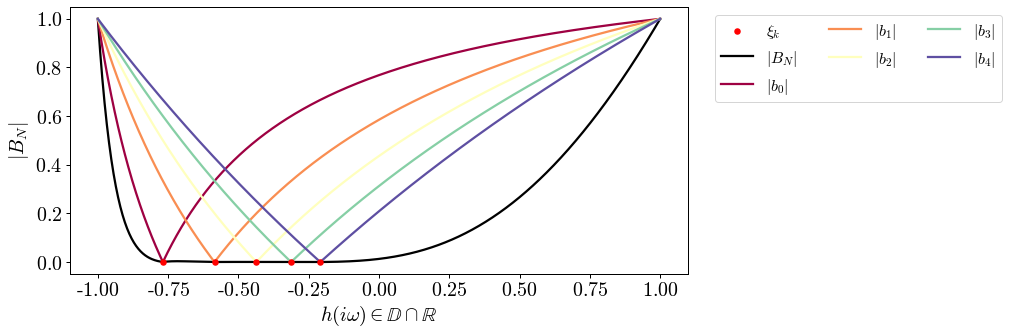

In [20]:
# Plot the Blashke product B_N on the real axis (should have zeros at the given frequencies)
re_axis = np.linspace(-1.0, 1.0, num = 1000)
# re_axis = np.linspace(start, stop, num = 1000)

import matplotlib as mpl
blaschke_cols = mpl.cm.get_cmap('Spectral')(np.linspace(0, 1, len(freq)))

fig, axes = pt.add_subplots()
ax1 = axes[0]

freq_style = default_style.copy()
freq_style['markersize'] = 100
pt.scatter_1d(np.real(zeta_list), np.zeros(len(freq)), ax = ax1, col = 'r', fn_label = r'$\xi_k$', zorder = 10, style = freq_style)
pt.plot_1d_data(re_axis, np.abs(np.array([B_N(x) for x in re_axis])), ax = ax1, fn_label = r'$|B_N|$', col = 'k')
for ii in range(len(freq)):
    pt.plot_1d_data(re_axis, np.abs(np.array([nv.blashke(x, zeta_list[ii]) for x in re_axis])), ax = ax1, \
                       fn_label = r'$|b_{' + str(ii) + r'}|$', ax_label=[r'$h(i\omega)\in\mathbb{D}\cap\mathbb{R}$', \
                       r'$|B_N|$'], col = blaschke_cols[ii])

ax1.legend(bbox_to_anchor=(1.52, 1), loc='upper right', ncol=3, fontsize = '16')
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/blashke_real_axis.pdf', bbox_inches = 'tight')

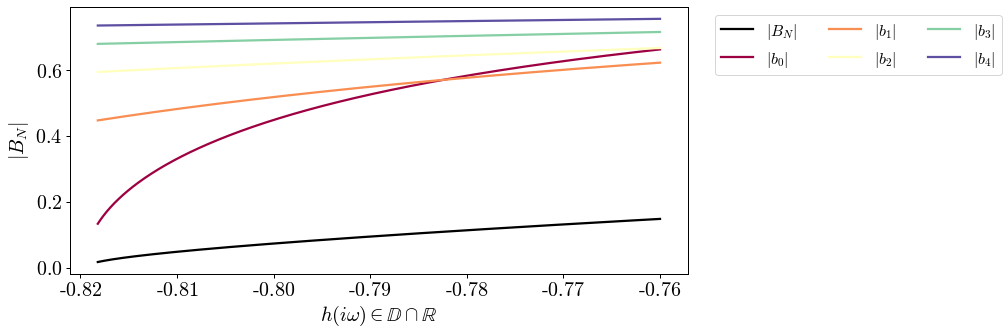

In [21]:
# Plot the Blashke product B_N on the evaluation axis
ev_axis = nv.moebius(np.linspace(start, stop, num = 1000) + 1j*eta)
# ev_axis = nv.moebius(np.linspace(-1.0, 1.0, num = 1000) + 1j*eta)

fig, axes = pt.add_subplots()
ax1 = axes[0]

pt.plot_1d_data(np.real(ev_axis), np.abs(np.array([B_N(x) for x in ev_axis])), ax = ax1, fn_label = r'$|B_N|$', col = 'k')
for ii in range(len(freq)):
    pt.plot_1d_data(np.real(ev_axis), np.abs(np.array([nv.blashke(x, zeta_list[ii]) for x in ev_axis])), ax = ax1, \
                      fn_label = r'$|b_{' + str(ii) + r'}|$', ax_label=[r'$h(i\omega)\in\mathbb{D}\cap\mathbb{R}$', \
                      r'$|B_N|$'], col = blaschke_cols[ii])

ax1.legend(bbox_to_anchor=(1.52, 1), loc='upper right', ncol=3, fontsize = '16')
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/blashke_eval_axis.pdf', bbox_inches = 'tight')

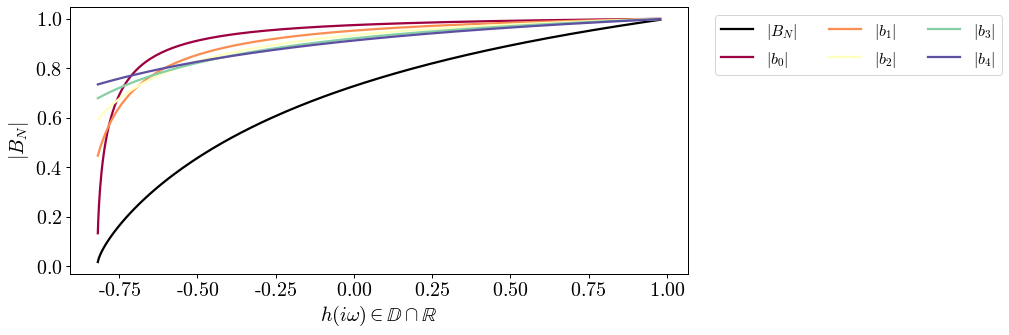

In [22]:
# Plot the Blashke product B_N on the evaluation axis
ev_axis = nv.moebius(np.linspace(0.0, 10.0, num = 1000) + 1j*eta)

fig, axes = pt.add_subplots()
ax1 = axes[0]

pt.plot_1d_data(np.real(ev_axis), np.abs(np.array([B_N(x) for x in ev_axis])), ax = ax1, fn_label = r'$|B_N|$', col = 'k')
for ii in range(len(freq)):
    pt.plot_1d_data(np.real(ev_axis), np.abs(np.array([nv.blashke(x, zeta_list[ii]) for x in ev_axis])), ax = ax1, \
                      fn_label = r'$|b_{' + str(ii) + r'}|$', ax_label=[r'$h(i\omega)\in\mathbb{D}\cap\mathbb{R}$', \
                      r'$|B_N|$'], col = blaschke_cols[ii])

ax1.legend(bbox_to_anchor=(1.52, 1), loc='upper right', ncol=3, fontsize = '16')
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/blashke_eval_axis_full.pdf', bbox_inches = 'tight')

### Evaluate $P_N S_N - Q_N R_N$ with double precision

In [23]:
# eval_line = nv.moebius(x + 1j*eta)
eval_line = nv.moebius(omega + 1j*eta)
B_N_eval = np.array([B_N(z) for z in eval_line])

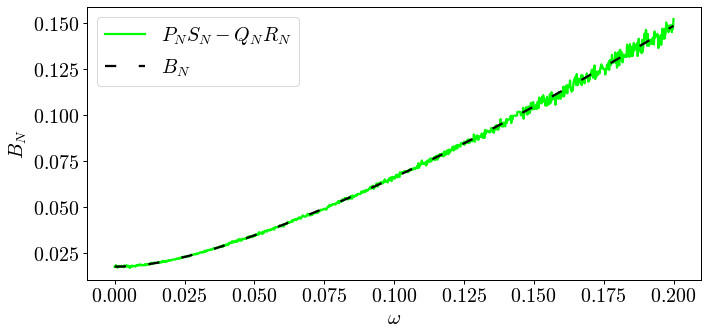

In [24]:
fig, axes = pt.add_subplots()
ax1 = axes[0]
det = nev_coeffs['P'] * nev_coeffs['S'] - nev_coeffs['Q'] * nev_coeffs['R']

pt.plot_1d_data(omega, np.abs(det), ax = ax1, fn_label=r'$P_N S_N - Q_N R_N$', col = 'lime')
pt.plot_1d_data(omega, np.abs(B_N_eval), ax = ax1, fn_label=r'$B_N$', col = 'k', linestyle = (0, (5, 10)))
pt.add_xlabel(ax1, r'$\omega$')
pt.add_ylabel(ax1, r'$B_N$')
ax1.legend(fontsize = default_style['fontsize'])
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/det_identity_double_prec.pdf', bbox_inches = 'tight')

### Evaluate $P_N S_N - R_N Q_N$ at extended precision

TODO: check out how the curves vary as we vary the number of input points

Once you go to a sufficiently large number of Matsubara frequencies, you need extended precision on the Nevanlinna coefficients to reproduce the desired identities. I'm not yet sure how this scales, but it might be a good idea to play with. 

The key here is that even if the input data is double precision and has error bars (i.e. it's imprecise), you **still need to keep extended precision on the Nevanlinna coefficients to reproduce the desired identities**. Even if your input data is not extended precision, the Nevanlinna problem is **still a well-defined mathematical problem**, and satisfies all the identities proved in the paper. However, to see these identities in action, you **must treat the problem with extended precision**. 

In [25]:
# prec = 128
prec = 1028
gmp.get_context().allow_complex = True
gmp.get_context().precision = prec

ONE = gmp.mpc(1, 0)
I = gmp.mpc(0, 1)
h = lambda z : (z - I) / (z + I)
hinv = lambda q : I * (gmp.mpc(1, 0) + q) / (gmp.mpc(1, 0) - q)
eta_mpc = gmp.mpc(eta_str)

def read_nev_coeffs_extended(fname):
    fname = '/Users/theoares/lqcd/spectral/simulations/' + fname
    with h5py.File(fname, 'r') as ifile:
        # Reconstructed frequencies
        start = np.array(ifile['start'][:], dtype=float).item()
        stop = np.array(ifile['stop'][:], dtype=float).item()
        num = np.array(ifile['num'][:], dtype=int).item()
        omega = np.linspace(start, stop, num=num)
        tmp = {}
        for key in ['P','Q','R','S']:
            tmp[f'{key}_re'] = np.array([gmp.mpc(x) for x in ifile[f'{key}_real'][()]], dtype=object)
            tmp[f'{key}_im'] = np.array([gmp.mpc(x) for x in ifile[f'{key}_imag'][()]], dtype=object)
        
        # DON'T NORMALIZE: destroys the identities we want to keep intact
        nev_coeffs = {}
        
        # Rephase a,b,c,d
        for key in ['P','Q','R','S']:
            nev_coeffs[key] = tmp[f'{key}_re'] + gmp.mpc(0, 1) * tmp[f'{key}_im']        
        # phi = phase(nev_coeffs['P'][0])
        # for key in nev_coeffs:
        #     nev_coeffs[key] = nev_coeffs[key]/phi
    return omega, nev_coeffs

omega_ext, nev_coeffs_ext = read_nev_coeffs_extended("recon_PICK.h5")

In [26]:
# Confirm the relation P_N S_N - Q_N R_N = B_N
def B_N_ext(z):
    b = ONE
    for hfreq in zeta_list:
        b *= nv.blashke(z, hfreq)
    return b
eval_line_ext = np.array([nv.moebius(gmp.mpc(xx) + I*eta) for xx in omega], dtype = 'object')
B_N_eval_ext = np.array([B_N_ext(z) for z in eval_line_ext])

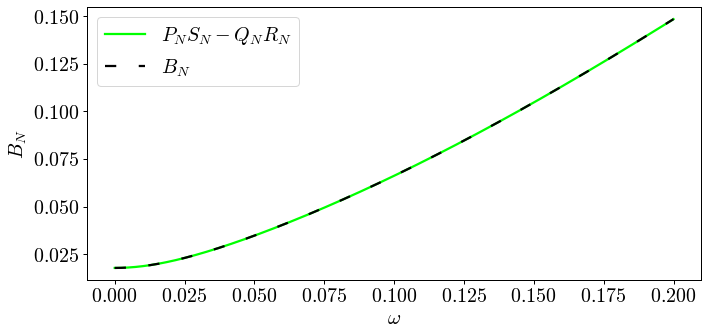

In [27]:
fig, axes = pt.add_subplots()
ax1 = axes[0]
det = np.complex128(nev_coeffs_ext['P'] * nev_coeffs_ext['S'] - nev_coeffs_ext['Q'] * nev_coeffs_ext['R'])

pt.plot_1d_data(omega, np.abs(det), ax = ax1, fn_label=r'$P_N S_N - Q_N R_N$', col = 'lime')
pt.plot_1d_data(omega, np.abs(np.complex128(B_N_eval)), ax = ax1, fn_label=r'$B_N$', col = 'k', linestyle = (0, (5, 10)))
pt.add_xlabel(ax1, r'$\omega$')
pt.add_ylabel(ax1, r'$B_N$')
ax1.legend(fontsize = default_style['fontsize'])
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/det_identity_ext_prec.pdf', bbox_inches = 'tight')

### Evaluate $|S_N|^2 - |R_N|^2$

Might be interesting to compute $|S|^2 - |R|^2$ at different $\eta$ values and plot them against one another. Analytically, we know that on the boundary of the disk $\partial\mathbb D$, this value should be 1:
$$
    |S_N|^2 - |R_N|^2 = 1.
$$

Note two things:
- This identity need only hold on the boundary of the disk, hence we may need to take $\eta\ll 1$ to see anything resembling this identity. Indeed for the two-pole reconstruction, I can't resolve anything going on with even the correct order of magnitude until we get down to about $\eta\sim 10^{-12}$, and even at that very small value of $\eta$ we still get weird fluctuations. Going smaller, we see the identity almost holding at $\eta = 10^{-16}$, but there's a lot of noise at large $\omega$. 
- It seems that numerically, $|S_N|^2 - |R_N|^2 = -1$ instead of $+1$ on the boundary of the disk. Should definitely figure out what's going on here, since this enters the vertevorrat construction. 

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:xlabel='$\\omega$', ylabel='$|S|^2 - |R|^2$'>)

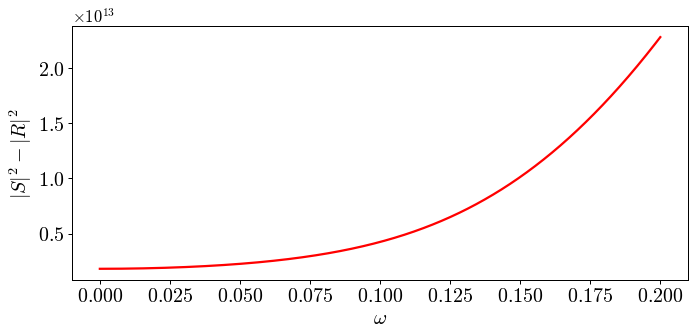

In [28]:
pt.plot_1d_data(omega, np.abs(nev_coeffs['S'])**2 - np.abs(nev_coeffs['R'])**2, fn_label=r'$|S|^2 - |R|^2$', \
                  ax_label = [r'$\omega$', r'$|S|^2 - |R|^2$'])

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Extended precision'}, xlabel='$\\omega$', ylabel='$|S|^2 - |R|^2$'>)

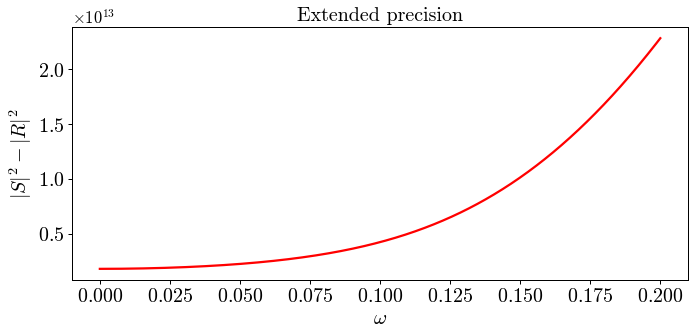

In [29]:
y = np.float64(mpc_abs(nev_coeffs_ext['S'])**2 - mpc_abs(nev_coeffs_ext['R'])**2)
pt.plot_1d_data(omega, y, fn_label=r'$|S|^2 - |R|^2$', ax_label = [r'$\omega$', r'$|S|^2 - |R|^2$'],\
                  title = 'Extended precision')

### Make sure I can reconstruct the spectral function with $\theta_{N+1} \equiv 0$

In [30]:
rho_zero_fn_disk = nev_coeffs_ext['Q'] / nev_coeffs_ext['S']
rho_zero_fn = hinv(rho_zero_fn_disk)

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Recon with $\\theta_{N+1} = 0$'}, xlabel='$\\omega$', ylabel='$\\rho$'>)

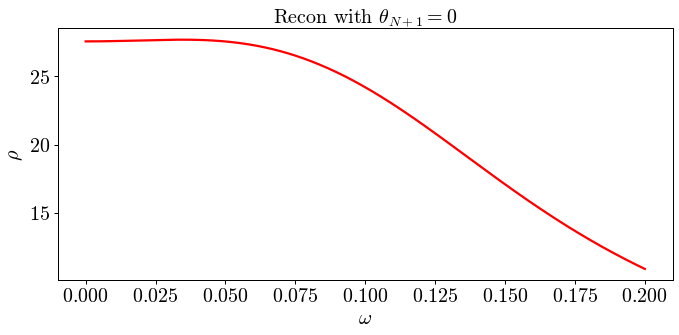

In [31]:
pt.plot_1d_data(omega, np.complex128(rho_zero_fn).imag, ax_label = [r'$\omega$', r'$\rho$'], \
                title = r'Recon with $\theta_{N+1} = 0$')

### Evaluate the center and radius of the solution disk

Analytically, the set of all possible solutions at $\zeta\in\mathbb D$ is 
$$
    \Delta(\zeta) := \{ f(\zeta) : f \text{ is a Nevanlinna interpolant}  \},
$$
and can be proven to be a Euclidean disk of center 
$$
    c_N(\zeta) := \frac{P_N(\zeta) \left( -\frac{R_N}{S_N}(\zeta) \right)^* + Q_N(\zeta)}{R_N(\zeta) \left( -\frac{R_N}{S_N}(\zeta) \right)^* + S_N(\zeta)} = \frac
    {Q_N(\zeta) \bar{S}_N(\zeta) - P_N(\zeta) \bar{R}_N(\zeta)}
    {|S_N(\zeta)|^2 - |R_N(\zeta)|^2}
$$
with radius:
$$
    \rho_N(\zeta) := \frac{|B_N(\zeta)|}{|S_N(\zeta)|^2 - |R_N(\zeta)|^2}.
$$
Note that solutions are in the disk, and need to be mapped back to the complex plane with $h^{-1}$. 

In [32]:
rN = mpc_abs(B_N_eval_ext) / (mpc_abs(nev_coeffs_ext['S'])**2 - mpc_abs(nev_coeffs_ext['R'])**2)
mRoverS_conj = mpc_conj( -nev_coeffs_ext['R'] / nev_coeffs_ext['S'] )
cN = (nev_coeffs_ext['P']*mRoverS_conj+nev_coeffs_ext['Q']) / (nev_coeffs_ext['R']*mRoverS_conj+nev_coeffs_ext['S'])

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Pullback of $c_N$'}, xlabel='$\\omega$', ylabel='$\\mathrm{Im}[h^{-1}\\circ c_N]$'>)

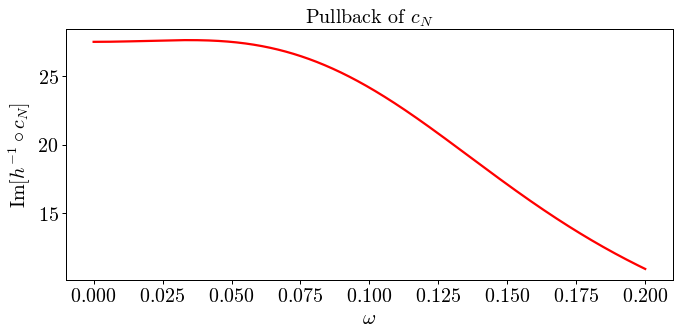

In [33]:
rho_center = hinv(cN)
pt.plot_1d_data(omega, np.complex128(rho_center).imag, title = r'Pullback of $c_N$', \
                  ax_label = [r'$\omega$', r'$\mathrm{Im}[h^{-1}\circ c_N]$'])

#### Plot the wertevorrat (both in $\mathbb D$ and in $\mathbb C^+$)

In [34]:
# now with error bands
ex_idx = 100
tt = np.linspace(0, 1, num = 100)
dDelta = np.zeros((len(cN), len(tt)), dtype = object)
dGamma = np.zeros((len(cN), len(tt)), dtype = object)
for ii in range(len(cN)):
    #dDelta[ii] = cN[ii] + rN[ii] * np.exp(2*np.pi*1j*tt)
    for tidx, t in enumerate(tt):
        dDelta[ii, tidx] = cN[ii] + rN[ii] * gmp.exp(gmp.mpc('2')*gmp.const_pi()*gmp.mpc(0, 1)*gmp.mpc(str(t)))
    #dDelta[ii] = cN[ii] + rN[ii] * gmp.exp(gmp.mpc('2')*gmp.const_pi()*gmp.mpc(0, 1)*tt)
    dGamma[ii] = hinv(dDelta[ii])
dDelta_float = np.complex128(dDelta)
dGamma_float = np.complex128(dGamma)
cN_float = np.complex128(cN)
rN_float = np.float64(rN)

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:xlabel='$\\mathrm{Re}[\\Gamma]$', ylabel='$\\mathrm{Im}[\\Gamma]$'>)

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


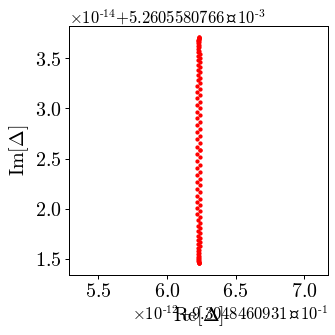

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


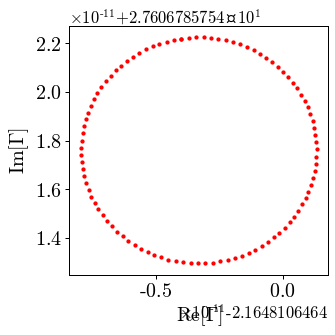

In [35]:
pt.scatter_1d(dDelta_float[ex_idx].real, dDelta_float[ex_idx].imag, fig_size = [5, 5], \
              ax_label = [r'$\mathrm{Re}[\Delta]$', r'$\mathrm{Im}[\Delta]$'])
pt.scatter_1d(dGamma_float[ex_idx].real, dGamma_float[ex_idx].imag, fig_size = [5, 5], \
              ax_label = [r'$\mathrm{Re}[\Gamma]$', r'$\mathrm{Im}[\Gamma]$'])

In [36]:
# TODO add a 1 / np.pi here
pi_Gamma = dGamma_float.imag
delta_rho_plus = np.max(pi_Gamma, axis = 1)
delta_rho_minus = np.min(pi_Gamma, axis = 1)

In [37]:
np.max(delta_rho_minus)

27.659415016227097

Currently the smeared spectral function is lying just outside the wertevorrat: what's going on here?
When the wertevorrat is smaller, it's obviously easier for the smeared $\rho$ to lie outside of it (i.e. you only see this as $\eta$ gets larger and larger) but (**think about and verify this**) the wertevorrat should always contain the ground truth smeared spectral function, no matter how small it is

In [38]:
# %matplotlib notebook

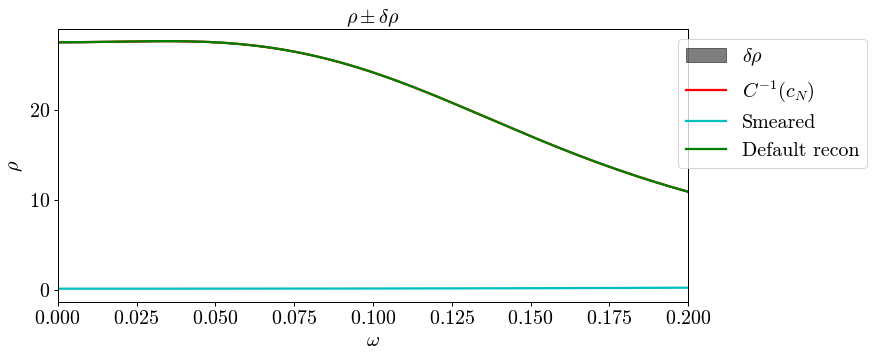

In [39]:
fig, axes = pt.add_subplots()
ax = axes[0]
ax.fill_between(omega, delta_rho_minus, delta_rho_plus, color = 'k', alpha = 0.5, label = r'$\delta\rho$')
pt.plot_1d_data(omega, np.complex128(rho_center).imag, ax = ax, col = 'r', fn_label = r'$C^{-1}(c_N)$')

# pt.plot_1d_data(omega, rho_smeared, ax = ax, col = 'c', fn_label = 'Smeared')
pt.plot_1d_data(omega_conv, rho_smeared_full, ax = ax, col = 'c', fn_label = 'Smeared')

# pt.plot_1d_data(omega, np.complex128(rho_center).imag, ax = ax, col = 'r', fn_label = r'$C^{-1}(c_N)$')
pt.plot_1d_data(omega, np.complex128(rho_zero_fn).imag, ax = ax, fn_label = r'Default recon', col = 'g')

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$\rho$')
ax.set_title(r'$\rho\pm\delta\rho$', fontsize = default_style['fontsize'])

ax.set_xlim((start, stop))
# ax.set_xlim((-1.0, 1.0))
# ax.set_xlim((0.54, 0.55))
# ax.set_ylim((0.8, 0.846))

# ax.set_xlim((0.78, 0.85))
# ax.set_ylim((-0.1, 2.0))

pt.stylize_axis(ax)
ax.legend(bbox_to_anchor=(1.3, 1), loc='upper right', fontsize = default_style['fontsize'])
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/wertevorrat_smeared_rho.pdf', bbox_inches = 'tight')

In [40]:
print('Default reconstruction (theta_{m+1} = 0) lies inside wertevorrat:')
print(np.all(np.logical_and(delta_rho_minus <= np.complex128(rho_zero_fn).imag, np.complex128(rho_zero_fn).imag <= delta_rho_plus)))
# print(np.logical_and(delta_rho_minus <= np.complex128(rho_zero_fn).imag, np.complex128(rho_zero_fn).imag <= delta_rho_plus))

# print('Smeared spectral function lies inside wertevorrat:')
# print(np.all(np.logical_and(delta_rho_minus <= np.complex128(rho_zero_fn).imag, np.complex128(rho_zero_fn).imag <= delta_rho_plus)))

Default reconstruction (theta_{m+1} = 0) lies inside wertevorrat:
True


(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'$(\\delta\\rho^+ - \\delta\\rho^-) / \\rho$'}, xlabel='$\\omega$', ylabel='$|\\delta\\rho| / \\rho$'>)

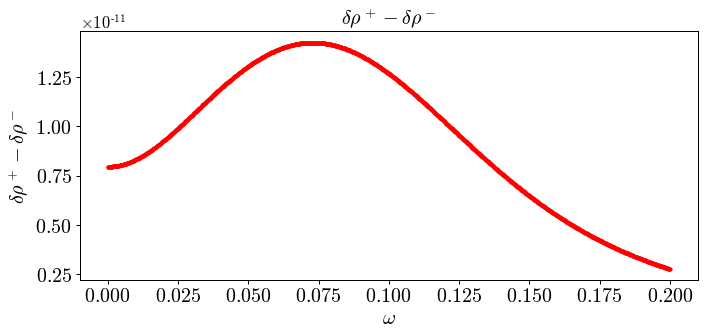

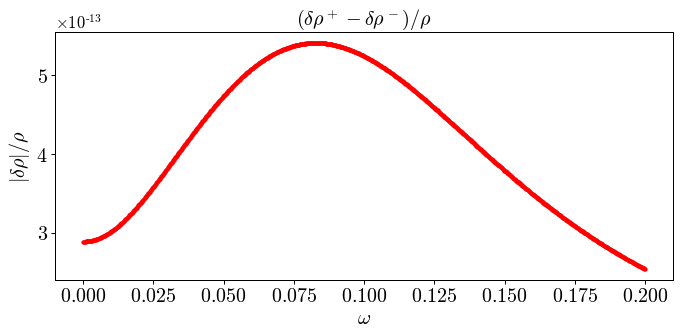

In [41]:
pt.scatter_1d(omega, delta_rho_plus - delta_rho_minus, ax_label = \
              [r'$\omega$', r'$\delta\rho^+ - \delta\rho^-$'], title = r'$\delta\rho^+ - \delta\rho^-$')
pt.scatter_1d(omega, (delta_rho_plus - delta_rho_minus) / np.complex128(rho_center).imag, ax_label = \
              [r'$\omega$', r'$|\delta\rho| / \rho$'], title = r'$(\delta\rho^+ - \delta\rho^-) / \rho$')

### Verify that $|S_N(\zeta)|$ is the largest Nevanlinna coefficient

In [42]:
bad_idxs = np.where(np.abs(cN_float) >= 1)[0]
print('Indices where |c_N|\geq 1: ' + str(bad_idxs))
# These indices correspond to points where $|S_N|^2 - |R_N|^2 has a zero crossing! This combination should always be positive (from the math paper)

Indices where |c_N|\geq 1: []


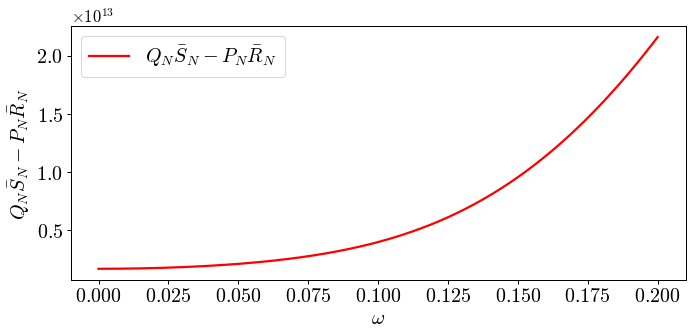

In [43]:
# Look at Q_N(\zeta) \bar{S}_N(\zeta) - P_N(\zeta) \bar{R}_N(\zeta)
fig, axes = pt.add_subplots()
ax1 = axes[0]
num_cN = np.complex128(nev_coeffs_ext['Q'] * mpc_conj(nev_coeffs_ext['S']) - nev_coeffs_ext['P'] * mpc_conj(nev_coeffs_ext['R']))

pt.plot_1d_data(omega, np.abs(num_cN), ax = ax1, fn_label=r'$Q_N \bar{S}_N - P_N \bar{R}_N$', col = 'r')
pt.add_xlabel(ax1, r'$\omega$')
pt.add_ylabel(ax1, r'$Q_N \bar{S}_N - P_N \bar{R}_N$')
ax1.legend(fontsize = default_style['fontsize'])
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/det_identity_ext_prec.pdf', bbox_inches = 'tight')

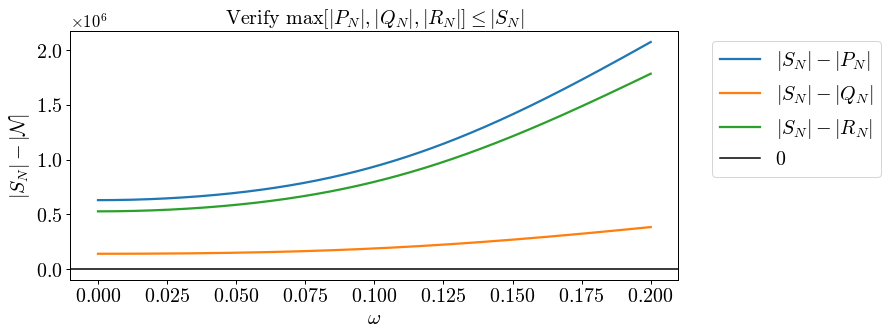

In [44]:
# Verify that |S| \geq |P|, |Q|, |R|
fig, axes = pt.add_subplots()
ax = axes[0]
for ii, key in enumerate(['P','Q','R']):
    pt.plot_1d_data(omega, np.abs(nev_coeffs['S']) - np.abs(nev_coeffs[key]), ax = ax, col = nev_cols[ii],\
                      ax_label = [r'$\omega$', r'$|S_N| - |\mathcal{N}|$'], fn_label = r'$|S_N| - |'+key+'_N|$', \
                      title = r'Verify $\max[|P_N|, |Q_N|, |R_N|] \leq |S_N|$')
pt.add_line(ax, 0, orientation = 'h', c = 'k', label = '0')
lbl = r'$|c_N| > 1$'
for tmp_idx in bad_idxs:
    pt.add_line(ax, omega[tmp_idx], c = 'c', label = lbl)
    lbl = '_nolegend_'
ax.legend(bbox_to_anchor=(1.35, 1), loc='upper right', fontsize = default_style['fontsize'])
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/broken_identity_gaussian.pdf', bbox_inches = 'tight')

Note that the following 3 plots are $\rho_N$, $\mathrm{Im}[c_N]$, and $\mathrm{Re}[c_N]$: these are still subsets of $\mathbb D$, so **don't expect them to look like anything you can interpret**!

In [45]:
# pt.plot_1d_data(omega, np.complex128(rN).real, title = r'Radius of $\Delta$', \
#                   ax_label = [r'$\omega$', r'$r_N$'])

In [46]:
# pt.plot_1d_data(omega, np.complex128(cN).real, title = r'Real part of center of $\Delta$', \
#                   ax_label = [r'$\omega$', r'$\mathrm{Re}[c_N]$'])
# pt.plot_1d_data(omega, np.complex128(cN).imag, title = r'Imaginary part of center of $\Delta$', \
#                   ax_label = [r'$\omega$', r'$\mathrm{Im}[c_N]$'], col = 'b')

**Figures to make**
1. Edit Cayley transform figure: color palette, think about arrows and $\pm \infty$ points, change notation to $C$ instead of $h$. Shift $C$ and $C^{-1}$ to be diagonal maps, can adjust $\mathbb C^+$ and $\mathbb D$ to be on the diagonal
2. Similar figure but for $\tilde{C}$
3. Cayley tranform figure for evaluation axis $\omega + i\eta$ and Matsubara frequencies.
4. Figure for pulling back wertevorrat into $\mathbb C^+$ and projecting it onto the imaginary axis.

**Next steps**
1. Make sure that Euclidean data is exact at extended precision: zero out any real part of NG when we start the problem (or imaginary part)
2. Use Pick matrix to diagnose when the data we're using has $\geq 1$ solution (add Pick matrix code to the cpp project)
3. Can play with Gaussian recon on 40 timeslices (really weird peaks there, namely the center $c_N$ of the wertevorrat lies outside the disk)
3. Smear spectral function and verify that it lies in the wertevorrat.
4. Approximate the Gaussian with a $\delta$ train and derive the analytic result for the Laplace transform (or use a multi-pole reconstruction and find a malicious counterexample)
5. Try to reconstruct $R$-ratio data

In [47]:
def kernel(omega, beta, tau):
    return (np.exp(-omega*tau) + np.exp(-omega*(beta-tau)))/(1 + np.exp(-beta*tau))

In [48]:
# beta = 48
# sigma = 0.1
# corrs = []
# # x_lst = []
# for N in [10, 100, 1000, 10000, 100000]:
#     x = np.linspace(0, 10*sigma, num=N)
#     #x_lst.append(x)
#     # x = np.linspace(0, 1, num=20000)
#     # rho = np.exp(-0.5*x**2/sigma**2)/(np.sqrt(2*np.pi)*sigma)
#     rho = np.exp(-0.5*(x - 0.5)**2/sigma**2)/(np.sqrt(2*np.pi)*sigma)
#     rho += np.exp(-0.5*(x + 0.5)**2/sigma**2)/(np.sqrt(2*np.pi)*sigma)
#     rho = 2*rho  # Unit normalized on [0, infinity)

#     print("Normalization of spectral density", np.trapz(x=x, y=rho))

#     # Euclidean-time correlator = Laplace transform of the spectral density
#     tau = np.arange(beta)  # Evaluate on the lattice grid [0, ..., beta-1]
#     corr = np.array([np.trapz(x=x, y=rho*kernel(x, beta, tau_i)) for tau_i in tau])
#     corrs.append(corr)
# corrs = np.array(corrs)

In [49]:
# # fig, ax = pt.add_subplots(ncol = 5)
# pt.scatter_1d(range(beta), corrs[0], logy=True)

In [50]:
# tau = 5
# pt.scatter_1d(range(1, 5), corrs[1:, tau])
# pt.scatter_1d(range(2, 5), corrs[2:, tau])
# pt.scatter_1d(range(3, 5), corrs[3:, tau])